In [3]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import matplotlib.style as style
import matplotlib.cm as cm
# Uncomment these to generate beautiful plots
# style.use('seaborn-poster')
# style.use('ggplot')
from skimage import io
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from skimage.transform import rescale, resize, downscale_local_mean
import cv2
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, ConfusionMatrixDisplay
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image as Image
from tensorflow.keras.utils import plot_model
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')

In [4]:
# Change this path to the directory of Dataset Directory
data_root = "./"
# Change the model_root to the directory of models saved
model_root = "../Deployment-Deep-Learning-Model/"

In [5]:
# tf.config.set_visible_devices([], 'GPU')
if tf.test.gpu_device_name():
    print('GPU found')
else:
    print("No GPU found")

No GPU found


# Load The Pre-Trained Models
1. Conv 2D
2. VGG19
3. MobileNet V2
4. ResNet 50

In [6]:
# MODEL_PATH_VGG = model_root + 'models/model_vgg19.h5'
# MODEL_PATH_CONV2D = model_root + 'models/model_conv_2d.h5'
# MODEL_PATH_MOBNETV2 = model_root + 'models/model_mobv2.h5'
# MODEL_PATH_RESNET50 = model_root + 'models/model_resnet50.h5'
# MODEL_PATH_INCEPTIONV3 = model_root + 'models/model_inceptionv3.h5'

# MODEL_PATH_VGG_FEATURES = model_root + 'models/vgg19_features.h5'
# MODEL_PATH_CONV_FEATURES = model_root + 'models/conv_features.h5'
# MODEL_PATH_SVM_VGG = model_root + 'models/model_svm_vgg19.sav'
# # MODEL_PATH_VGG_CONV_DENSE = model_root + 'models/vgg19_with_conv_dense.h5'
# MODEL_PATH_RF_VGG = model_root + 'models/model_rf_vgg19.sav'
# # Load trained model ONLY TRANSFER LEARNING
# model_vgg = load_model(MODEL_PATH_VGG)
# model_conv_2d = load_model(MODEL_PATH_CONV2D)
# model_mobv2 = load_model(MODEL_PATH_MOBNETV2)
# model_resnet50 = load_model(MODEL_PATH_RESNET50)
# model_incep = load_model(MODEL_PATH_INCEPTIONV3)

# # Hybrid Models
# model_vgg_features = load_model(MODEL_PATH_VGG_FEATURES)
# model_svm_vgg = pickle.load(open(MODEL_PATH_SVM_VGG, "rb"))
# model_rf_vgg = pickle.load(open(MODEL_PATH_RF_VGG, "rb"))

In [7]:

# Sequential Model PATH
CONV2D_CLASSIFIER = model_root + 'models/conv2d_classifier.h5'

# Transfer Learning Model PATH
VGG_CLASSIFIER = model_root + 'models/transfer_learning_models/vgg19_classifier.h5'
MOBNETV2_CLASSIFIER = model_root + 'models/transfer_learning_models/mobv2_classifier.h5'
RESNET50_CLASSIFIER = model_root + 'models/transfer_learning_models/resnet50_classifier.h5'
INCEPTIONV3_CLASSIFIER = model_root + 'models/transfer_learning_models/inceptionv3_classifier.h5'

# Hybrid Learning Model PATH

VGG19_FEATURES = model_root + 'models/hybrid_models/vgg19_features.h5'
# MODEL_PATH_CONV_FEATURES = 'models/conv_features.h5'
SVM_VGG = model_root + 'models/hybrid_models/svm_vgg19_2.sav'
RF_VGG = model_root + 'models/hybrid_models/rf_vgg19.sav'
VGG_CONV_DENSE = model_root + 'models/hybrid_models/vgg19_conv_dense.h5'

# Machine Learning Model PATH
SVM = model_root + "models/ml_models/svm.sav"
RF = model_root + "models/ml_models/rf.sav"
LR = model_root + "models/ml_models/log_reg.sav"
KNN = model_root + "models/ml_models/knn.sav"
NB = model_root + "models/ml_models/nb.sav"

In [8]:
# Load TRANSFER LEARNING
model_vgg = load_model(VGG_CLASSIFIER)
model_mobv2 = load_model(MOBNETV2_CLASSIFIER)
model_resnet50 = load_model(RESNET50_CLASSIFIER)
model_incep = load_model(INCEPTIONV3_CLASSIFIER)

# load SEQUENTIAL Models
model_conv_2d = load_model(CONV2D_CLASSIFIER)

# Load Hybrid Models
model_vgg_features = load_model(VGG19_FEATURES)
model_svm_vgg = pickle.load(open(SVM_VGG, "rb"))
model_rf_vgg = pickle.load(open(RF_VGG, "rb"))

In [9]:
model_conv_2d.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_35 (Conv2D)          (None, 299, 299, 32)      416       
                                                                 
 batch_normalization_35 (Bat  (None, 299, 299, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_35 (MaxPoolin  (None, 149, 149, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_36 (Conv2D)          (None, 148, 148, 64)      8256      
                                                                 
 batch_normalization_36 (Bat  (None, 148, 148, 64)     256       
 chNormalization)                                                
                                                      

In [10]:
# All the figures will be saved in this directory
if not os.path.exists('./Figures'):
    os.makedirs('./Figures')

# Instantiate Image Data Generators

In [11]:
train_gen = ImageDataGenerator(rescale=1/255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
val_gen = ImageDataGenerator(rescale=1/255)

In [12]:
def getTrainTest(dims, batch_size):
    """
    This function returns the train generator and val generator for the models
        
         Parameters:
            dims (array or tuple): Dimension to resize the input images
            batch_size (int): Batch size for the data
        Returns:
            (train_generator, validation_generator)
    """
    DIMS = dims
    root = data_root
    train = train_gen.flow_from_directory(root + "RashData/Train/Train_2_Cases", target_size=(DIMS[0], DIMS[1]),
                                        batch_size=batch_size, class_mode='binary')
    val = val_gen.flow_from_directory(root + "RashData/Validation/Validation_2_Cases", target_size=(DIMS[0], DIMS[1]),
                                       batch_size=batch_size, class_mode='binary')
    return (train, val)

# Generate Confusion Matrix and Classification Report for a model 

In [13]:
def getConfusionMatrix(model, validation, batch_size, th=0.4, get_dict=True):
    """
    This Function returns the confusion matrix plot and classification report of the model
    
        Parameters:
            model : Keras Model
            validation: Validation generator
            batch_size (int): Batch size of the data
            th (float): thresold value if binary classifier
            get_dict (bool): True if classification report return type is dict and False if string
    """
    validation.reset()
    y_true = validation.classes
    
    Y_pred = model.predict_generator(validation, validation.n // batch_size + 1)
    if th != None:
        Y_pred = Y_pred > th
        Y_pred = Y_pred.astype('int')
        Y_pred = Y_pred[:,0]
        
    labels = ["Negative", "Positive"]
    conf_mat = confusion_matrix(y_true, Y_pred)
    class_report = classification_report(y_true, Y_pred, target_names=labels, output_dict=get_dict)
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=labels)
    
    return (disp, class_report)

# Plot different plots related to accuracy, auc and loss
##### Plots that are generated:
1. Plots of Training accuracy, Validation Accuracy vs Epochs
2. Plots of Training Loss, Validation Loss vs Epochs
3. Plots of Training AUC, Validation AUC vs Epochs
4. Plot of Confusion Matrix

In [14]:
def plot_train_val_accuracy(model, history, train, val, epoch, disp=None, save_name="unknown"):
    """
    This Function produces the plots for training accuracy, auc, loss
    and validation accuracy, auc, loss and saves them in provided location
    
        Parameters:
            model: Keras model
            history: keras model history object or saved history in dictionary or dataframe
            train: Train generator
            val: Validation generator
            epoch: No of epochs used to train the model
            disp: Confusion matrix plot
            save_name: Model Name in which the figure will be saved
    """
    train.reset()
    val.reset()
    
    if train != None and val != None:
        score_val = model.evaluate(val)
        score_train = model.evaluate(train)
        print('Test Loss:', score_val[0])
        print('Test accuracy:', score_val[1])
        print('Train Loss:', score_train[0])
        print('Train accuracy:', score_train[1])
        
    # For ROC 
    

    # plot accuracy
    
    epochs_range = range(1, epoch+1)
    
    fig, ax = plt.subplots(2, 2, figsize=(20, 10))
    
    ax[0][0].plot(epochs_range, history['accuracy'])
    ax[0][0].plot(epochs_range, history['val_accuracy'])
    ax[0][0].set_title('Model Accuracy')
    ax[0][0].set_ylabel('Accuracy')
    ax[0][0].set_xlabel('Epoch')
    ax[0][0].legend(['Train Accuracy', 'Validation Accuracy'])
    
    if disp != None:
        disp.plot(ax=ax[0][1])
        disp.ax_.set_title("Confusion Matrix")
    
    ax[1][0].plot(epochs_range, history['loss'])
    ax[1][0].plot(epochs_range, history['val_loss'])
    ax[1][0].set_title('Model Loss')
    ax[1][0].set_ylabel('Loss')
    ax[1][0].set_xlabel('Epoch')
    ax[1][0].legend(['Train Loss', 'Validation Loss'])
    
    ax[1][1].plot(epochs_range, history['auc'])
    ax[1][1].plot(epochs_range, history['val_auc'])
    ax[1][1].set_title('Model AUC')
    ax[1][1].set_ylabel('AUC')
    ax[1][1].set_xlabel('Epoch')
    ax[1][1].legend(['Train AUC', 'Validation AUC'])
    
    fig.tight_layout(pad=3.0)
    fig.savefig('./Figures/' + save_name + ".png", bbox_inches='tight')

# Comparison Chart of Models
> All the models are compared on basis of different performance metrics

In [15]:
def plot_model_comparison(cr_list, model_names):
    """
    This function plots the different performance metrics for each class 
    for each models and saves the figures
    
        Parameters:
            cr_list (array): Array of classification reports of the models
            model_names (array): Array of model names
    """
    
    # We will save the f1 score, recalls and precision and support in following structure
    # curr_metric[class] = [cr_1.curr_metric, cr_2.curr_metric, ...]
    
    f1_scores = {}
    recalls = {}
    precisions = {}
    supports = {}
    
    for cls in ["Positive", "Negative"]:
        f1_scores[cls] = list([cr[cls]["f1-score"] for cr in cr_list])
        recalls[cls] = list([cr[cls]["recall"] for cr in cr_list])
        precisions[cls] = list([cr[cls]["precision"] for cr in cr_list])
        supports[cls] = list([cr[cls]["support"] for cr in cr_list])
        
    fig, axes = plt.subplots(2, 2, figsize=(20, 10))
    X = np.arange(len(model_names))
    
    axes[0][0].bar(X, precisions["Positive"], color="crimson", width = 0.25)
    axes[0][0].bar(X + 0.25, precisions["Negative"], color="darkcyan", width=0.25)
    axes[0][0].set_title("Precision Comparison")
    axes[0][0].set_xlabel("Models")
    axes[0][0].set_ylabel("Precision")
    
    axes[0][1].bar(X, f1_scores["Positive"], color="crimson", width=0.25)
    axes[0][1].bar(X + 0.25, f1_scores["Negative"], color="darkcyan", width=0.25)
    axes[0][1].set_title("F1 Score Comparison")
    axes[0][1].set_xlabel("Models")
    axes[0][1].set_ylabel("f1 score")
    
    axes[1][0].bar(X, recalls["Positive"], color="crimson", width=0.25)
    axes[1][0].bar(X + 0.25, recalls["Negative"], color="darkcyan", width=0.25)
    axes[1][0].set_title("Recall Comparison")
    axes[1][0].set_xlabel("Models")
    axes[1][0].set_ylabel("recall")
    
    axes[1][1].bar(X, supports["Positive"], color="crimson", width=0.25)
    axes[1][1].bar(X + 0.25, supports["Negative"], color="darkcyan", width=0.25)
    axes[1][1].set_title("Support Comparison")
    axes[1][1].set_xlabel("Models")
    axes[1][1].set_ylabel("support")
    
    for i in range(2):
        for j in range(2):
            axes[i][j].set_xticks([i + 0.25 for i in range(len(model_names))], model_names)
            axes[i][j].legend(['Positive', 'Negative'])
            
    fig.tight_layout(pad=2.0)
    fig.savefig("./Figures/comparison.png", bbox_inches="tight")

# Plot intermediate outputs in a model

In [16]:
def plot_interm_act(classifier, no_of_layers, img_path, img_size, model_name=None):
    """
    Visualizes the intermediate outputs in a neural network model
        
        Parameters:
            classifier: tf.keras Model
            no_of_layers (int): Number of layers from top for which vizualisation is required
            img_path (str): Path of test image
            img_size (tuple): Requires dimension for input in classifier
            model_name (str): Name of the input classifier if any
            
        Returns:
            None
    """
    
    if model_name != None:
        print("Plotting first", no_of_layers, "of the", model_name, "model.")
    else:
        model_name = "unknown_model"
    
    path_to_save = ".Figures/Intermediate_activations/" + model_name
    
    if not os.path.exists(path_to_save):
        os.makedirs(path_to_save)
        print("Activation images will be saved in" + path_to_save)
        
    # Selecting first 'no_of_layers' no of layers from the classifier
    output_layers = [layer.output for layer in classifier.layers[:no_of_layers + 1]]
    
    # Defining the input layer
    input_layer = classifier.input
    # Instanciating the model
    model =  keras.Model(inputs=input_layer, outputs=output_layers)
    
    # Loading the image from the given image path
    ## Transforming the loaded image to array
    ### Expanding the dimensions -- Because Keras needs one extra dimension
    img = Image.load_img(img_path, target_size=img_size)
    img_tensor = Image.img_to_array(img)
    img_tensor = np.expand_dims(img_tensor, axis=0)
    
    
    # Plotting the three different color channels of the input image
    input_grid = np.zeros((img_size[0] * 1, img_size[0] * 3))
    input_grid[0:img_size[1], 0 * img_size[1]: 1 * img_size[1]] = img_tensor[0,:,:,0]
    input_grid[0:img_size[1], 1 * img_size[1]: 2 * img_size[1]] = img_tensor[0,:,:,1]
    input_grid[0:img_size[1], 2 * img_size[1]: 3 * img_size[1]] = img_tensor[0,:,:,2]    
    plt.title('input_layer')
    plt.imshow(input_grid)

    # Normalizing the values of the image tensor
    img_tensor /= 255.
    print("Shape of current resized image: ", img_tensor.shape)
    
    # Feeding the image tensor to the model and getting saving outputs of each layer in 'activations'
    activations = model.predict(img_tensor)
    
    # Saving the corresponding layer names for plotting
    layer_names = list([layer.name for layer in classifier.layers[:no_of_layers+1]])
    
    # Iterating through all layers
    for layer_name, activation in zip(layer_names, activations):
        plots_per_row = 16 # No of channels to be plotted in each row
        
        no_of_channels = activation.shape[-1] # No of channels in current output layer
        
        # If current no of channels is less than 'plots_per_row'
        if no_of_channels < plots_per_row:
            plots_per_row = no_of_channels
        
        # Size of the current output -- no_of_cols == no_of_row in output
        size = activation.shape[1]
        
        # No of row's required
        no_row = no_of_channels // plots_per_row
        
        # Defining a grid in which all channels of current layer is concatenated
        grid = np.zeros((size * no_row, plots_per_row * size))
    
        for i in range(no_row):
            for j in range(plots_per_row):
                channel_img = activation[0,:,:,i * plots_per_row + j]
                
                # Normalizing the image
                channel_img -= channel_img.mean()
                channel_img /= channel_img.std()
                channel_img *= 64
                channel_img += 128
                channel_img = np.clip(channel_img, 0, 255).astype('uint8')
            
                # Adding the current channel to the grid
                grid[i * size:(i + 1) * size, j * size:(j + 1) * size] = channel_img
        
        # Scaling the current grid
        scale = 1 / size
        plt.figure(figsize=(scale*grid.shape[1], scale*grid.shape[0]))
        plt.imshow(grid, aspect='auto')
        plt.title(layer_name)
#         plt.grid(b=None)
        plt.savefig(path_to_save + '/' + layer_name + '.png', bbox_inches='tight')

# Plotting the Grad-CAM figures 
> Grad-CAM figures help us to observe the main area where the model is concentrating

In [17]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = Image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = Image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array /= 255.
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, name="cam", alpha=0.4):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    plt.subplot(1, 2, 1)
    plt.grid(b=None)
    plt.imshow(img)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    plt.subplot(1,2,2)
    plt.imshow(superimposed_img)
    plt.grid(b=None)
    plt.savefig("./Figures/" + name + ".png", bbox_inches='tight')
#     superimposed_img.save(cam_path)

In [18]:
# Load lOG FILES

# Change root_log according to the directory of logs folder
root_log = ''
hist_conv2d = pd.read_csv(root_log + './logs/conv2d.csv')
hist_vgg19 = pd.read_csv(root_log + './logs/vgg19.csv')
hist_mobnet = pd.read_csv(root_log + './logs/mobnetv2.csv')
hist_resnet = pd.read_csv(root_log + './logs/resnet50.csv')
hist_incep = pd.read_csv(root_log + './logs/inceptionv3.csv')
display(hist_mobnet)

epoch  accuracy       auc      loss            lr  val_accuracy   val_auc  \
0       0  0.621777  0.681896  1.411218  1.000000e-03        0.6500  0.769826   
1       1  0.799427  0.875276  0.481282  1.000000e-03        0.6500  0.782227   
2       2  0.862464  0.937248  0.316063  1.000000e-03        0.8125  0.870844   
3       3  0.885387  0.943104  0.296603  1.000000e-03        0.7625  0.875651   
4       4  0.891117  0.953492  0.270725  1.000000e-03        0.7250  0.851237   
..    ...       ...       ...       ...           ...           ...       ...   
95     95  0.982808  0.997559  0.053022  5.000000e-07        0.8125  0.897059   
96     96  0.994269  0.999797  0.029803  5.000000e-07        0.7875  0.914571   
97     97  0.974212  0.996856  0.077140  5.000000e-07        0.7750  0.867619   
98     98  0.988539  0.999613  0.040315  5.000000e-07        0.8250  0.911025   
99     99  0.974212  0.997672  0.070133  5.000000e-07        0.7750  0.874597   

    val_loss  
0   2.420440  
1   1.195369  
2   0.588501  
3   0.728346  
4   0.614173  
..       ...  
95  0.528117  
96  0.456017  
97  0.614715  
98  0.437366  
99  0.662235  

[100 rows x 8 columns]

In [19]:
test_img_path = "./RashData/Lyme_Positive_By_Diease/EMRash/erythema migrans32.jpg"

Found 378 images belonging to 2 classes.
Found 93 images belonging to 2 classes.
Found 378 images belonging to 2 classes.
Found 93 images belonging to 2 classes.
38/38 [==============================] - 22s 583ms/step - loss: 0.1802 - accuracy: 0.9418 - auc: 0.9793
Test Loss: 0.6031946539878845
Test accuracy: 0.7634408473968506
Train Loss: 0.1801847219467163
Train accuracy: 0.9417989253997803
38/38 [==============================] - 32s 814ms/step - loss: 1.7909 - accuracy: 0.9206 - auc: 0.9664
Test Loss: 2.874706983566284
Test accuracy: 0.6451612710952759
Train Loss: 1.7909282445907593
Train accuracy: 0.920634925365448
38/38 [==============================] - 51s 1s/step - loss: 0.6810 - accuracy: 0.5767 - auc: 0.5125
Test Loss: 0.6865572929382324
Test accuracy: 0.5376344323158264
Train Loss: 0.6810011863708496
Train accuracy: 0.5767195820808411
38/38 [==============================] - 35s 910ms/step - loss: 0.8630 - accuracy: 0.9418 - auc: 0.9760
Test Loss: 1.323980689048767
Test acc

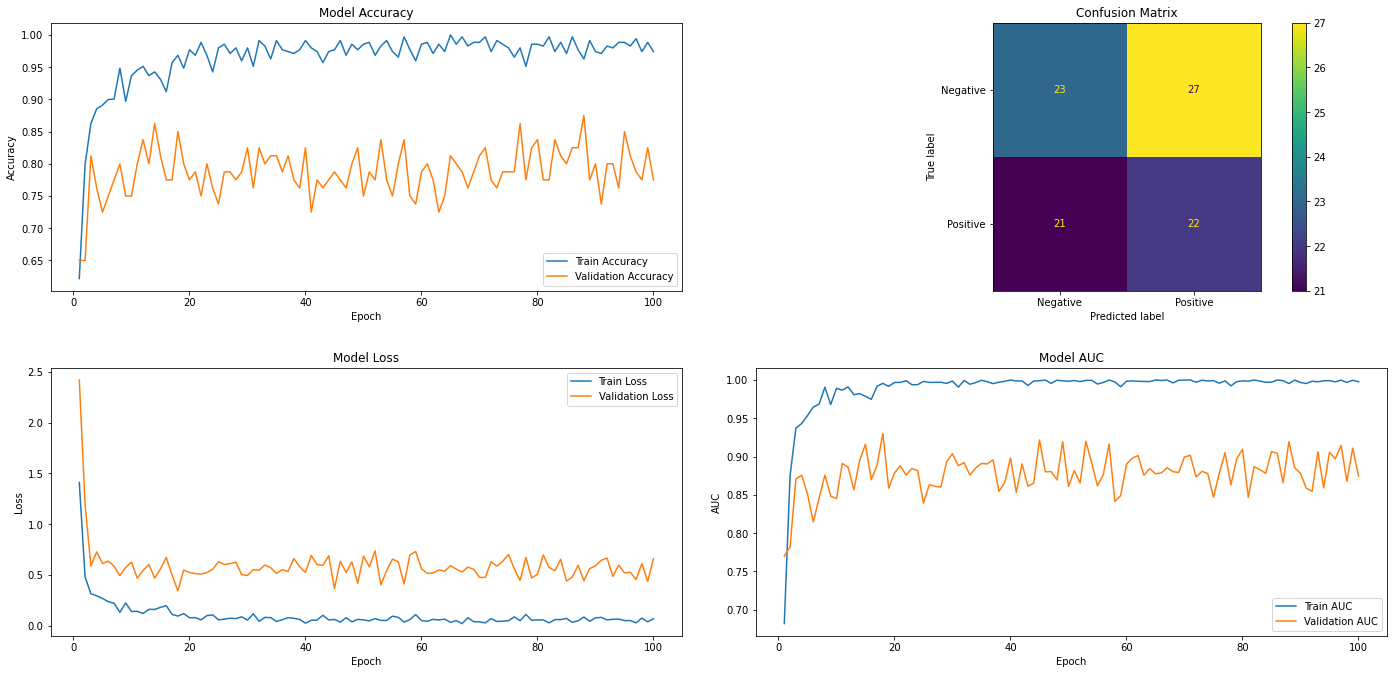

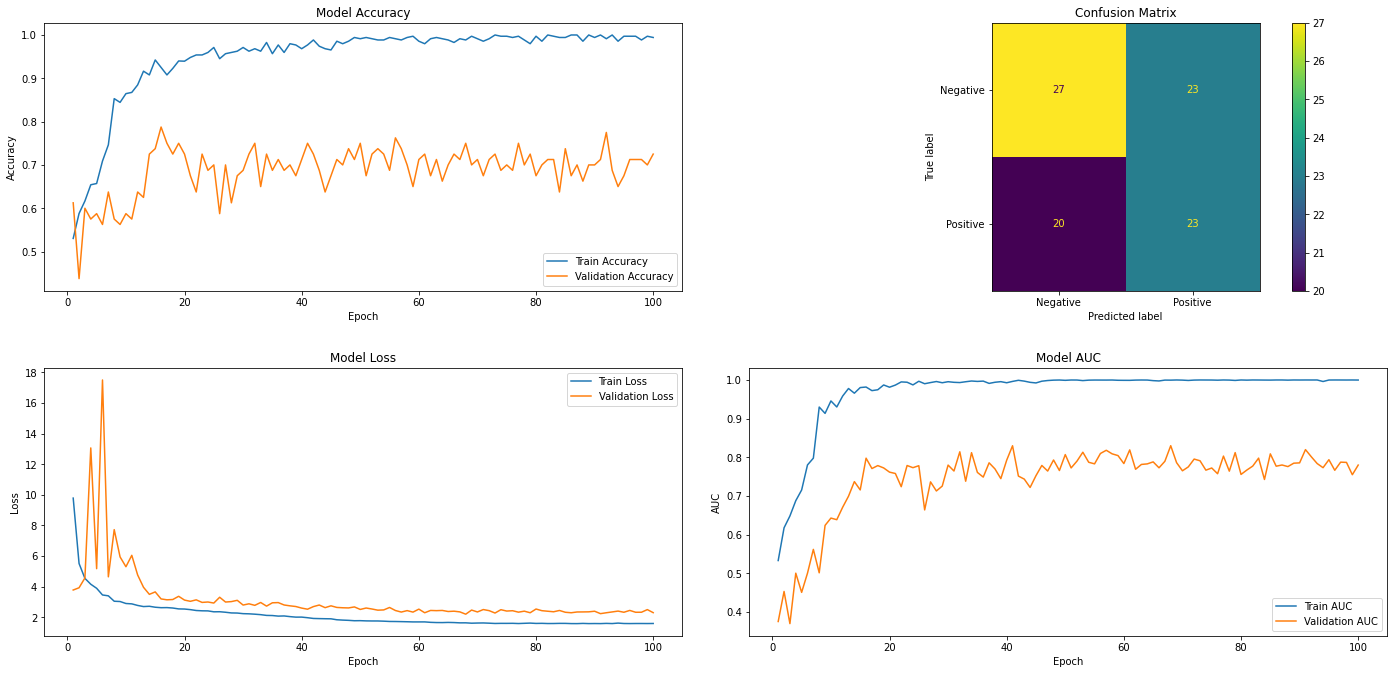

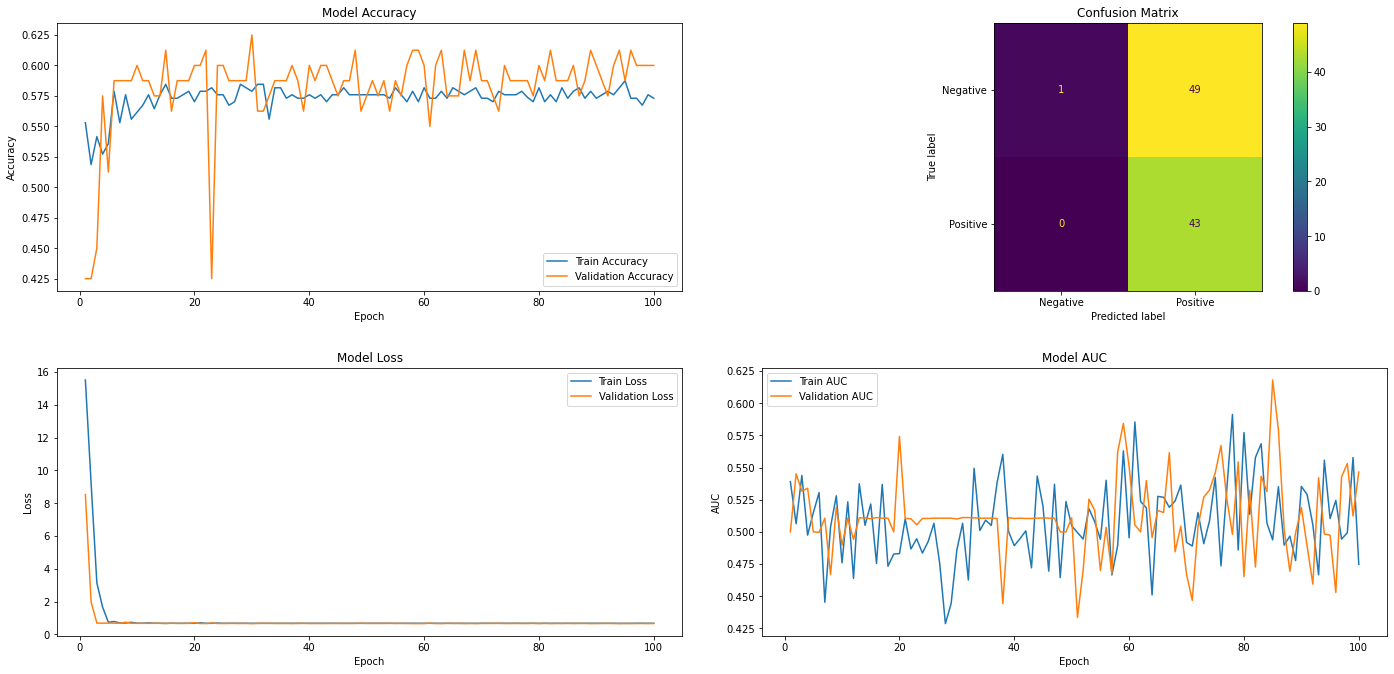

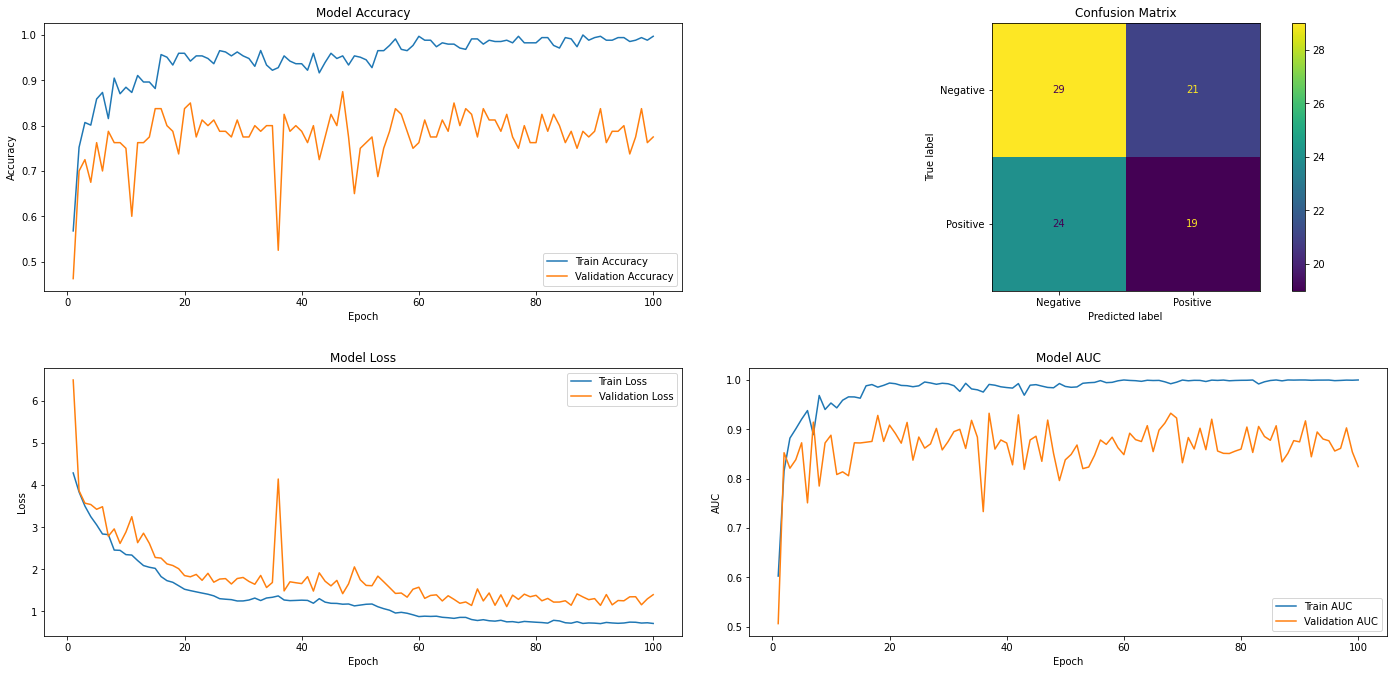

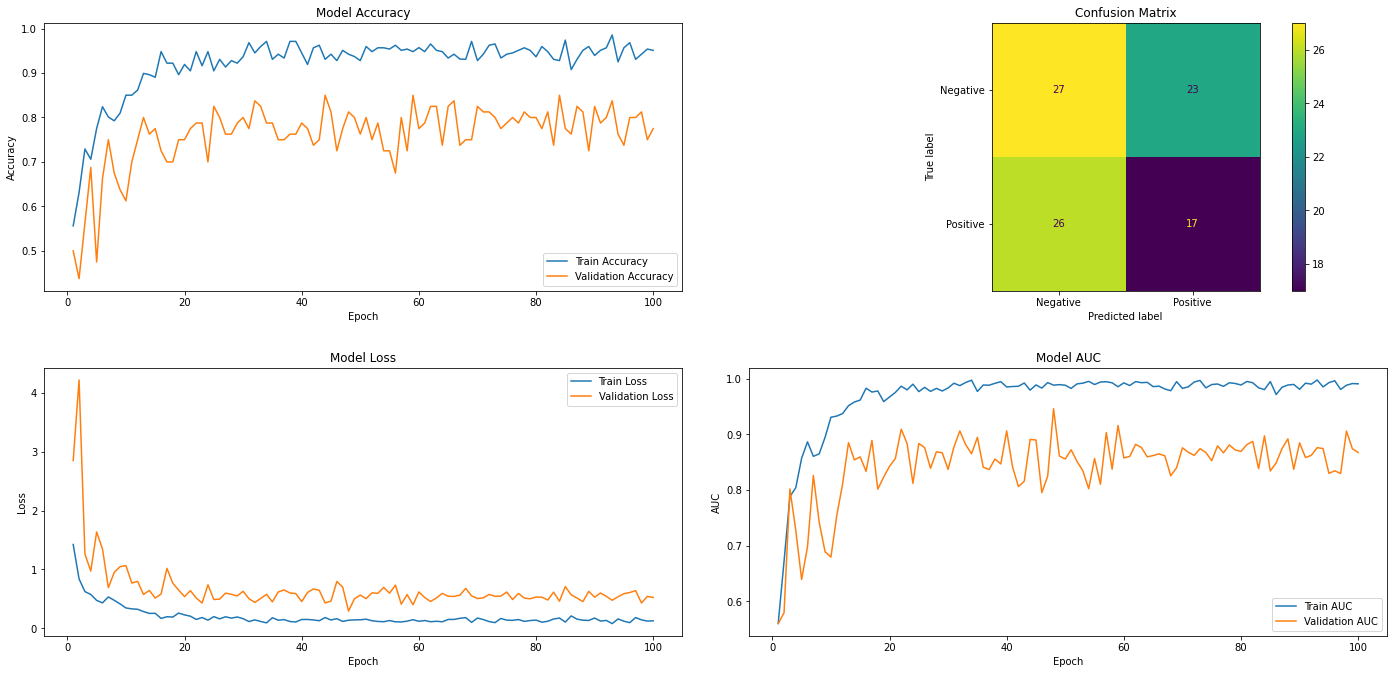

In [20]:
# Generating the train and validation generators for Conv2D(Where input image size = (300 * 300 * 3))
# And other state of the art models where input size = 224 * 224 * 3
train, val = getTrainTest((224, 224, 3), 10)
train_conv, val_conv = getTrainTest((300, 300, 3), 10)

disp_mobnet, cr_mobnet = getConfusionMatrix(model_mobv2, val, 10)
plot_train_val_accuracy(model_mobv2, hist_mobnet, train, val, 100, disp=disp_mobnet, save_name="MobileNetV2")

disp_conv, cr_conv = getConfusionMatrix(model_conv_2d, val_conv, 10)
plot_train_val_accuracy(model_conv_2d, hist_conv2d, train_conv, val_conv, 100, disp=disp_conv, save_name="CONV2D")

disp_resnet, cr_resnet = getConfusionMatrix(model_resnet50, val, 10)
plot_train_val_accuracy(model_resnet50, hist_resnet, train, val, 100, disp=disp_resnet, save_name="ResNet50")

disp_incep, cr_incep = getConfusionMatrix(model_incep, val, 10)
plot_train_val_accuracy(model_incep, hist_incep, train, val, 100, disp=disp_incep, save_name="InceptionV3")

disp_vgg, cr_vgg = getConfusionMatrix(model_vgg, val, 10)
plot_train_val_accuracy(model_vgg, hist_vgg19, train, val, 100, disp=disp_vgg, save_name="VGG19")

In [21]:
model_names = ["MobileNetV2", "VGG19", "Conv2D", "ResNet50", "InceptionV3"]

# Saving the classification report of each model in the array 
cr_list = [cr_mobnet, cr_vgg, cr_conv, cr_resnet, cr_incep]

In [18]:
# for i in range(len(cr_list)):
#     print("=============================================")
#     print(model_names[i])
#     print(cr_list[i])

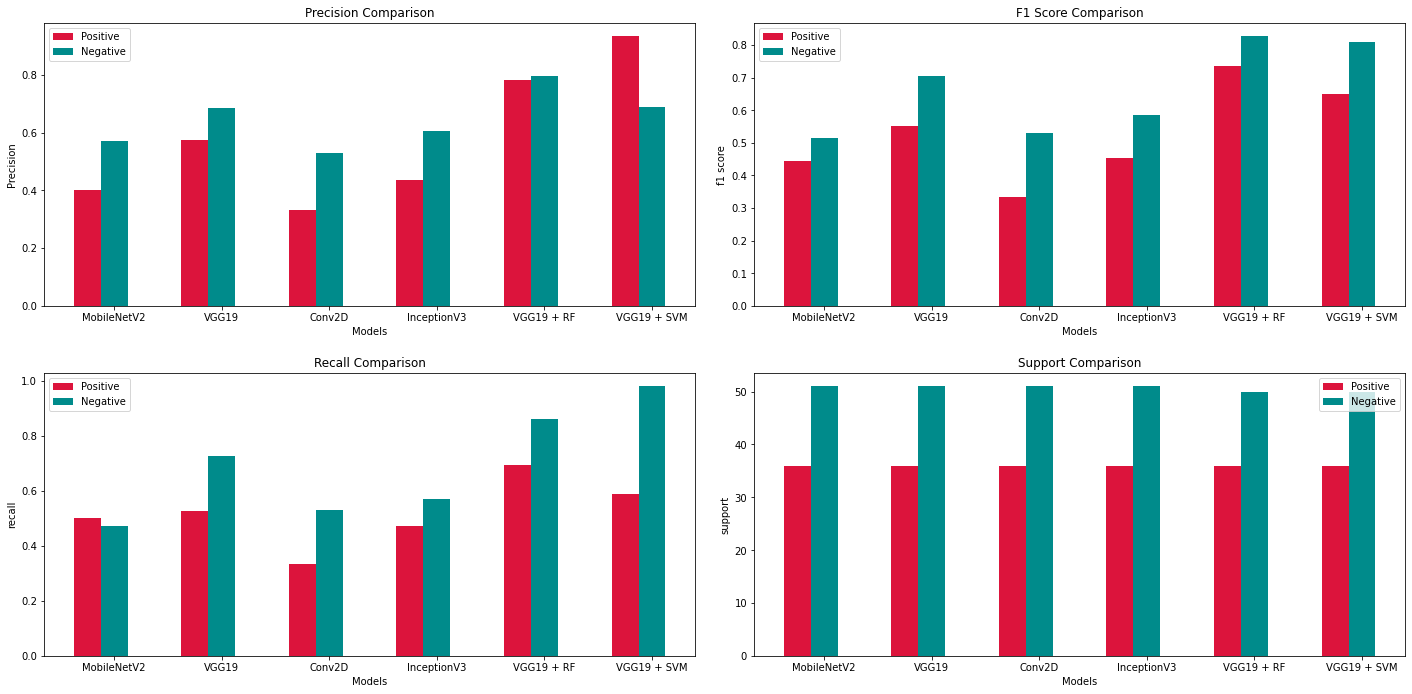

In [32]:
plot_model_comparison(cr_list, model_names)

Plotting first 5 of the VGG19 Features model.
Activation images will be saved in.Figures/Intermediate_activations/VGG19 Features
Shape of current resized image:  (1, 224, 224, 3)


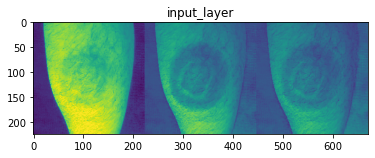

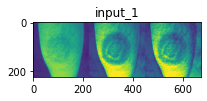

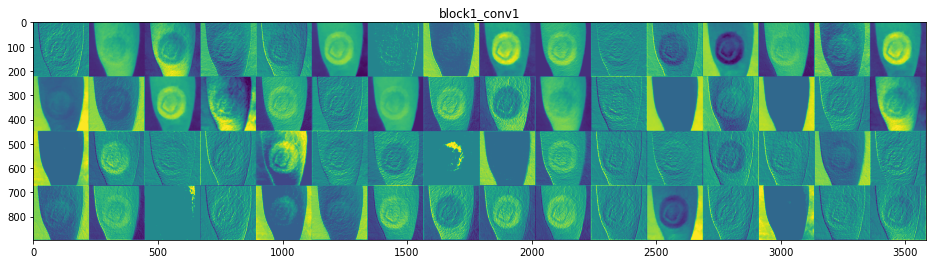

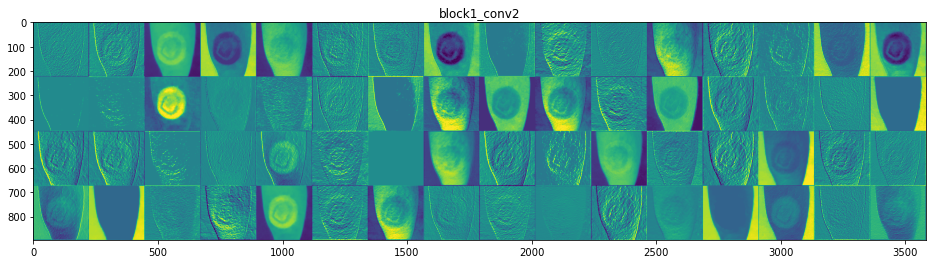

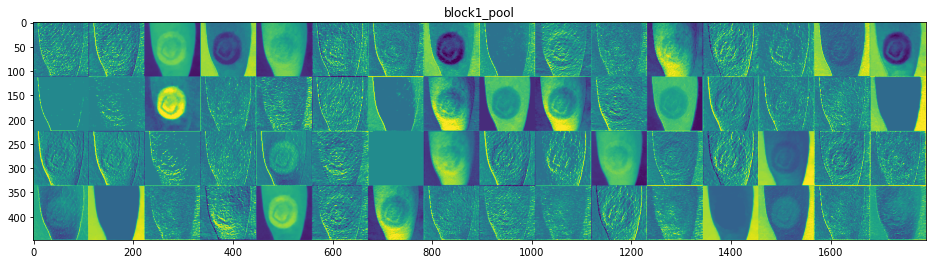

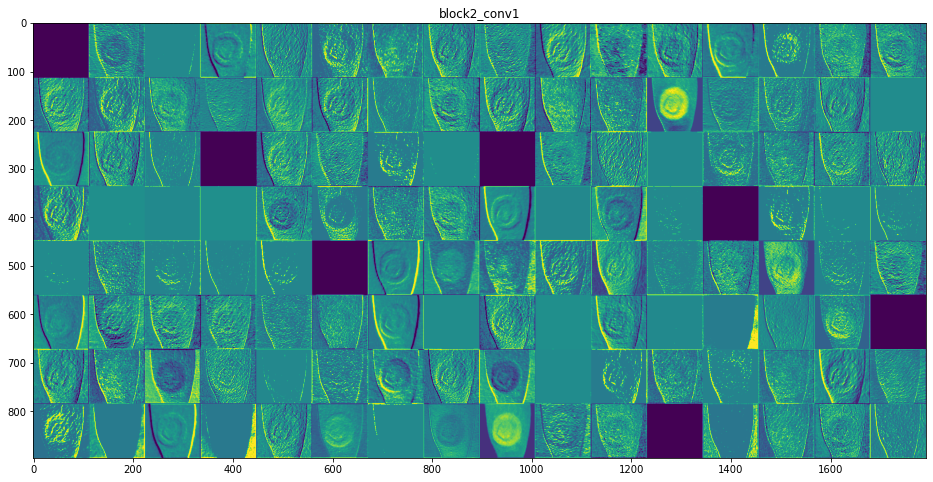

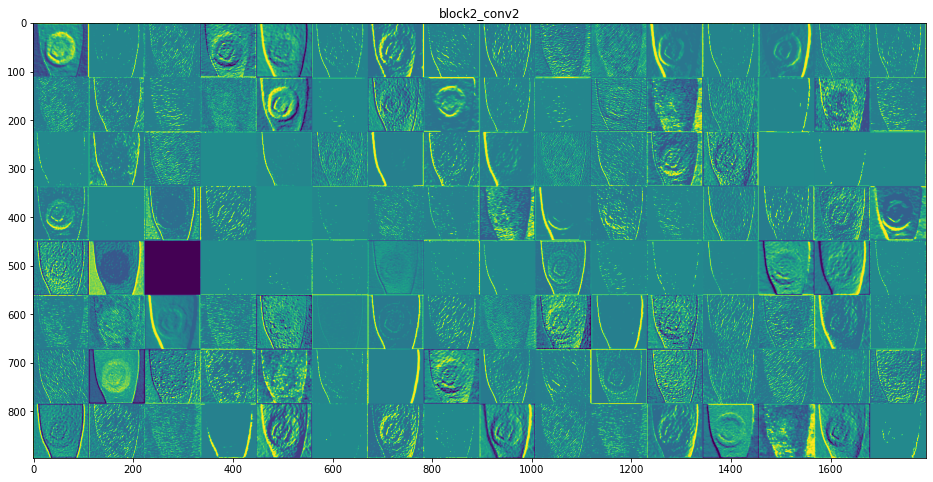

In [19]:
# Lets observe first 12 layer outputs of VGG19 Models
plot_interm_act(model_vgg_features, 5, test_img_path, (224, 224, 3), model_name="VGG19 Features")

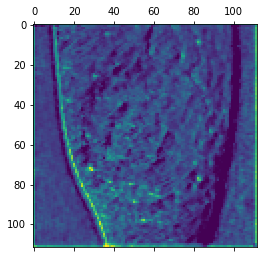

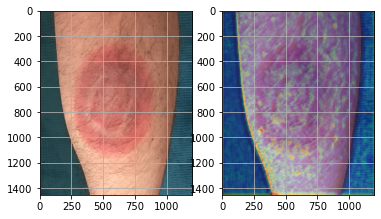

In [18]:
# Plotting Grad-CAM of second conv layer of VGG19
last_conv_layer_name = "block2_conv2"
img_size = (224, 224)
img_array = get_img_array(test_img_path, size=img_size)
heatmap = make_gradcam_heatmap(img_array, model_vgg_features, last_conv_layer_name)
plt.matshow(heatmap)
plt.show()
save_and_display_gradcam(test_img_path, heatmap, name='VGG19_b2_c2')

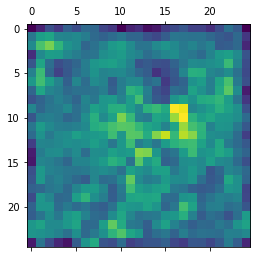

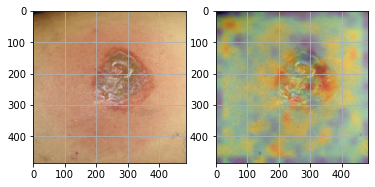

In [46]:
# Plotting Grad-CAM of 15th conv layer of Inception V3
last_conv_layer_name = "conv2d_15"
img_size = (224, 224)
img_array = get_img_array(test_img_path, size=img_size)
heatmap = make_gradcam_heatmap(img_array, model_incep, last_conv_layer_name)
plt.matshow(heatmap)
plt.show()
save_and_display_gradcam(test_img_path, heatmap, name='incep_con_15')

In [47]:
# Prepare image
# img_array = model_vgg.preprocess_input(get_img_array(img_path, size=img_size))
# # Make model
# model = model_builder(weights="imagenet")

# # Remove last layer's softmax
# model.layers[-1].activation = None

# # Print what the top predicted class is
# preds = model.predict(img_array)
# print("Predicted:", decode_predictions(preds, top=1)[0])

# Generate class activation heatmap

# Display heatmap


In [56]:
## Roc Curve
def plot_roc_curve(model_list, model_names, val):
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))
    axes[0].plot([0, 1], [0, 1], 'k--')
    for i in range(len(model_names)):
        model = model_list[i]
#         val.reset()
        y_pred = model.predict(val, val.n // val.batch_size + 1).ravel()
#         y_pred = y_pred > 0.4
#         y_pred = y_pred.astype('int')
#         y_pred = y_pred[:,0]
        fpr, tpr, th = roc_curve(val.classes, y_pred)
        auc_curr = auc(fpr, tpr)
        axes[0].plot(fpr, tpr, label='{} (area = {:.3f})'.format(model_names[i], auc_curr))
    axes[0].set_xlabel('False positive rate')
    axes[0].set_ylabel('True positive rate')
    axes[0].legend(model_names)
    plt.show()

In [57]:
model_list = [model_mobv2, model_vgg, model_conv_2d, model_resnet50, model_incep]

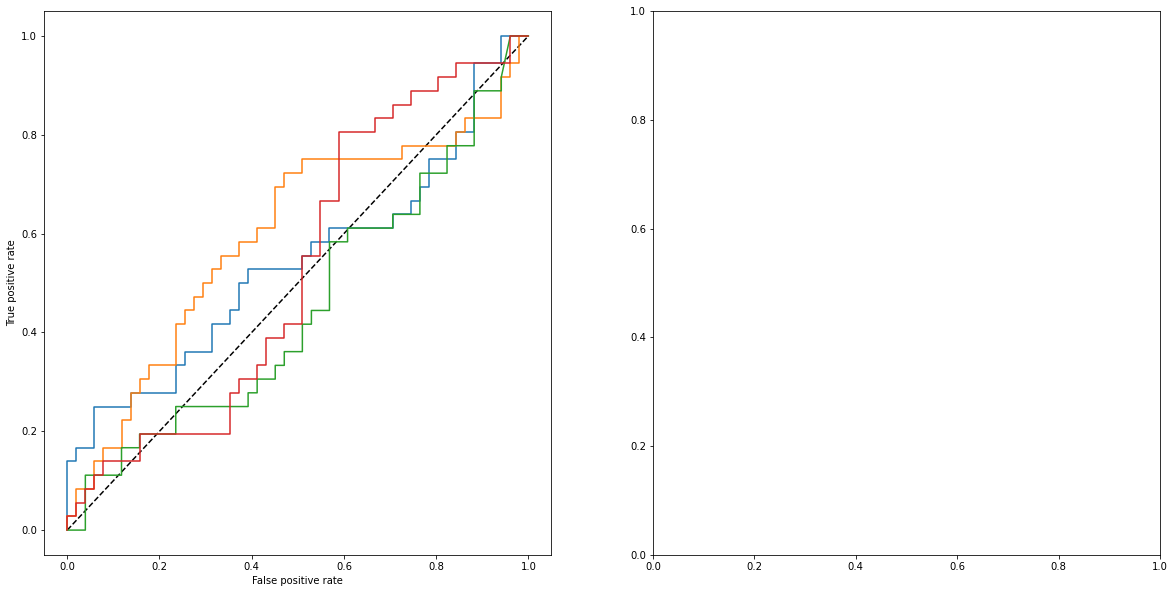

In [60]:
plot_roc_curve(model_list[0:2] + model_list[3:], model_names[0:2] + model_names[3:], val)

In [4]:
def get_table(hist):
    hist_new = hist.copy()
    hist_new['accuracy'] = hist['accuracy'] * 100
    hist_new['val_accuracy'] = hist['val_accuracy'] * 100
    hist_new.drop('lr', axis=1, inplace=True)
    hist_new.drop('epoch', axis=1, inplace=True)
    display(hist_new.iloc[::10])
    display(hist_new.tail(1))

In [5]:
get_table(hist_resnet)

accuracy       auc       loss  val_accuracy   val_auc  val_loss
0   55.300862  0.539013  15.512531     42.500001  0.500000  8.529478
10  56.733525  0.523363   0.682427     58.749998  0.510638  0.680166
20  57.879657  0.510088   0.712948     60.000002  0.510417  0.669823
30  58.452719  0.506681   0.677869     56.250000  0.511111  0.680284
40  57.306588  0.494748   0.681335     58.749998  0.510638  0.672440
50  57.593125  0.499479   0.682022     58.749998  0.433591  0.672844
60  57.306588  0.585401   0.680665     55.000001  0.505366  0.689135
70  57.306588  0.489010   0.683384     58.749998  0.446809  0.672967
80  57.020056  0.513674   0.683780     58.749998  0.532237  0.672785
90  57.593125  0.529027   0.680783     58.749998  0.489039  0.672470

accuracy       auc     loss  val_accuracy   val_auc  val_loss
99  57.306588  0.474732  0.68284     60.000002  0.546549   0.66878

In [46]:
test_img_path = "./RashData/Lyme_Positive_By_Diease/EMRash/erythema migrans72.jpg"

In [62]:
# Visualize individual channels
def plot_img_channel(img_path, color):
    img = Image.load_img(img_path)
    img = Image.img_to_array(img)
    if len(img.shape) != 3:
        print("RGB image is required")
        return 
    
    k = 0
    if color.lower() == 'g':
        k = 1
    elif color.lower() == 'b':
        k = 2
    
    for i in [0,1,2]:
        if i != k:
            continue
        img[:,:,i] = 0
    
    plt.imshow(Image.array_to_img(img))

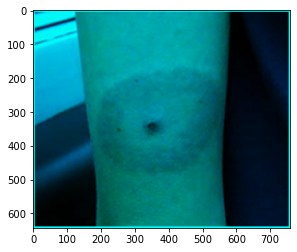

In [63]:
plot_img_channel(test_img_path, 'r')

In [30]:
rf_cl_report = {'Negative': {'precision': 0.7962962962962963, 
                      'recall': 0.86, 'f1-score': 0.826923076923077, 'support': 50
                     }, 
                'Positive': {'precision': 0.78125, 
                      'recall': 0.6944444444444444, 'f1-score': 0.7352941176470588, 'support': 36
                     }, 
                'accuracy': 0.7906976744186046, 
                'macro avg': {'precision': 0.7887731481481481, 'recall': 0.7772222222222223, 
                              'f1-score': 0.7811085972850679, 'support': 86}, 
                'weighted avg': {'precision': 0.7899978466838932, 'recall': 0.7906976744186046, 
                                 'f1-score': 0.7885667683889297, 'support': 86}
               }
cr_list.append(rf_cl_report)
model_names.append("VGG19 + RF")

In [31]:
svm_cl_report = {'Negative': {'precision': 0.6901408450704225, 'recall': 0.98, 'f1-score': 0.8099173553719008, 'support': 50}, 
                 'Positive': {'precision': 0.9333333333333333, 'recall': 0.5888888888888889, 'f1-score': 0.6490196078431373, 'support': 36}, 
                 'accuracy': 0.7325581395348837, 
                 'macro avg': {'precision': 0.8117370892018779, 'recall': 0.6844444444444444, 'f1-score': 0.679468481607519, 'support': 86}, 
                 'weighted avg': {'precision': 0.7919423517851294, 'recall': 0.7325581395348837, 'f1-score': 0.7007043447784649, 'support': 86}
                }

cr_list.append(svm_cl_report)
model_names.append("VGG19 + SVM")

In [16]:
# Train SVM
svms = {}
labels = ["Negative", "Positive"]
def train_svm(kernel, x_train, y_train, x_test, y_test):
    res = [kernel]
    for C in [20, 30, 40, 50]:
        svm = SVC(kernel=kernel, gamma='auto', C=C)
        svm.fit(x_train, y_test, probabillity=True)
        Y_pred = svm.predict(x_test)
        cl_report = classification_report(y_test, Y_pred, target_names=labels, output_dict=True)
        if kernel not in svms:
            svms[kernel] = {}
        if str(C) not in svms[kernel]:
            svms[kernel][str(C)] = None
        svms[kernel][str(C)] = cl_report


In [22]:
# Load Data
def load_from_directory(path, color_mode='rgb', normalize=True, augment=False):
    images = []
    labels = []
    DIMS = (224, 224, 3)
    path_root = "" + path
    categories = ["Negative", "Positive"]

    for category in categories:
        path = os.path.join(path_root, "Lyme_" + category)
        for img in os.listdir(path):
            try:
                img_path = os.path.join(path, img)
                img = Image.load_img(img_path, target_size=(DIMS[0], DIMS[1]), color_mode=color_mode)
                img_tensor = Image.img_to_array(img)
    #             image = np.array(dis_img).flatten()
                
                images.append(img_tensor)
                labels.append("Lyme_" + category)
                
                if augment == True:
                    aug_img_tensor = augment_img(img_tensor)
                    #aug_img_tensor = Image.img_to_array(aug_img)
                    images.append(aug_img_tensor)
                    labels.append("Lyme_" + category)
            except Exception as e:
                print(e)
#     images.pop(0)
#     labels.pop(0)
    images = np.array(images)
    labels = np.array(labels)
    plt.imshow(Image.array_to_img(images[0]))
    if normalize:
        images /= 255.
    le = LabelEncoder()
    labels = le.fit_transform(labels)
    return (images, labels)

In [23]:
train_path = "./RashData/Train/Train_2_Cases"
test_path = "./RashData/Validation/Validation_2_Cases"

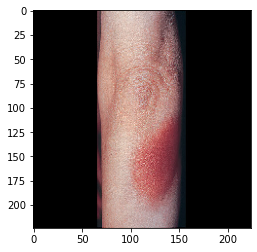

In [24]:
train_images, train_labels = load_from_directory(train_path)
test_images, test_labels = load_from_directory(test_path)

In [25]:
# One-Hot-Encode
x_train, y_train, x_test, y_test = train_images, train_labels, test_images, test_labels
y_train_en = keras.utils.to_categorical(y_train)
y_test_en = keras.utils.to_categorical(y_test)
print(y_test[0:5])
print(y_test_en[0:5])

[0 0 0 0 0]
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [26]:
x_train_rf = model_vgg_features.predict(x_train)
x_test_rf = model_vgg_features.predict(x_test)

In [28]:
# Train SVM
labels = ["Negative", "Positive"]
svms = {}
kernel_names = ["poly", "sigmoid", "rbf"]
cl_kernel = []
def train_svm(kernel, x_train, y_train, x_test, y_test):
    print(kernel)
    svm = SVC(kernel=kernel, gamma='auto', C=50, probability=True)
    svm.fit(x_train, y_train)
    svms[kernel] = svm
    Y_pred = svm.predict(x_test)
    cl_report = classification_report(y_test, Y_pred, target_names=labels, output_dict=True)
    cl_kernel.append(cl_report)

In [29]:
for kernel in kernel_names:
    train_svm(kernel, x_train_rf, y_train, x_test_rf, y_test)

poly
sigmoid
rbf


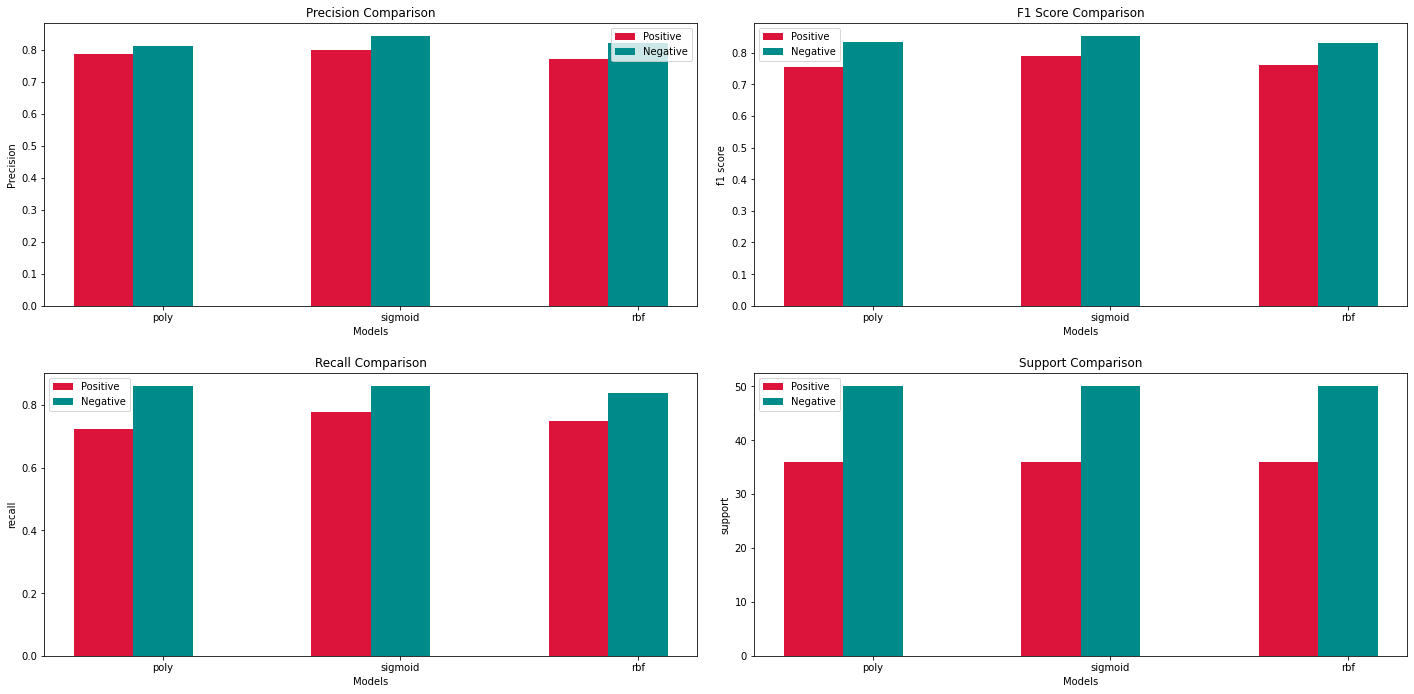

In [30]:
plot_model_comparison(cl_kernel, kernel_names)

In [31]:
for cl in cl_kernel:
    print(cl["accuracy"])

0.8023255813953488
0.8255813953488372
0.8023255813953488


In [32]:
pickle.dump(svms["sigmoid"], open(model_root + "/models/model_svm_vgg19_2.sav", "wb"))

In [23]:
rf_vgg = RandomForestClassifier(n_estimators=170, random_state=42, probability=True)

TypeError: __init__() got an unexpected keyword argument 'probability'

In [ ]:
Y_pred = rf_vgg.predict(x_test)
cl_report = classification_report(y_test, Y_pred, target_names=labels, output_dict=True)
print(cl_report)

# Generate Comparison of All Models

In [33]:
def generate(models, x_test, y_test):
    y_pred = x_test
    for model in models:
        y_pred = model.predict(y_pred)
    
    cl_report = classification_report(y_test, y_pred, output_dict=True)
    cl_report["Positive"] = cl_report["1"]
    del cl_report["1"]
    cl_report["Negative"] = cl_report["0"]
    del cl_report["0"]
    return cl_report

In [27]:
cr_ann = pickle.load(open("./crs_ann", "rb"))

In [28]:
names = cr_ann["name"]
all_cr = cr_ann["cr"]
print(len(all_cr))

5


In [29]:
names += model_names
all_cr += cr_list

In [30]:
len(names)

10

In [31]:
hyb_names = ["VGG19 + SVM", "VGG19 + RF"]
hyb_models = [[model_vgg_features, model_svm_vgg], [model_vgg_features, model_rf_vgg]]
hyb_cr = []

In [34]:
for i in range(2):
    cr = generate(hyb_models[i], x_test, y_test)
    hyb_cr.append(cr)

In [35]:
names += hyb_names
all_cr += hyb_cr

In [36]:
names

['LR',
 'SVM',
 'KNN',
 'RF',
 'NB',
 'MobileNetV2',
 'VGG19',
 'Conv2D',
 'ResNet50',
 'InceptionV3',
 'VGG19 + SVM',
 'VGG19 + RF']

In [37]:
all_cr_df = pd.DataFrame({
    "Model": names,
    "Accuracy": list([cr["accuracy"] * 100 for cr in all_cr]),
    "Weighted_Macro_F1": list([cr['weighted avg']['f1-score'] * 100 for cr in all_cr]),
    "Weighted_Macro_Recall": list([cr['weighted avg']['recall'] * 100 for cr in all_cr]),
    "Weighted_Macro_Precision": list([cr['weighted avg']['precision'] *100 for cr in all_cr])
});

In [43]:
pos = pd.DataFrame({
    "Model": names,
    "Precision(%)": list(["{:.2f}".format(cr["Positive"]["precision"] * 100) for cr in all_cr]),
    "Recall(%)": list(["{:.2f}".format(cr['Positive']['recall'] * 100) for cr in all_cr]),
    "F1 Score(%)": list(["{:.2f}".format(cr['Positive']['f1-score'] * 100) for cr in all_cr]),
    "Support": list(["{:.2f}".format(cr['Positive']['support']) for cr in all_cr])
});
display(pos)

Model Precision(%) Recall(%) F1 Score(%) Support
0            LR        75.00     71.05       72.97   76.00
1           SVM        49.18     39.47       43.80   76.00
2           KNN        79.17     25.00       38.00   76.00
3            RF        79.37     65.79       71.94   76.00
4            NB        52.38     57.89       55.00   76.00
5   MobileNetV2        44.90     51.16       47.83   43.00
6         VGG19        42.50     39.53       40.96   43.00
7        Conv2D        50.00     53.49       51.69   43.00
8      ResNet50        46.74    100.00       63.70   43.00
9   InceptionV3        47.50     44.19       45.78   43.00
10  VGG19 + SVM        75.61     72.09       73.81   43.00
11   VGG19 + RF        77.78     65.12       70.89   43.00

In [44]:
neg = pd.DataFrame({
    "Model": names,
    "Precision(%)": list(["{:.2f}".format(cr["Negative"]["precision"] * 100) for cr in all_cr]),
    "Recall(%)": list(["{:.2f}".format(cr['Negative']['recall'] * 100) for cr in all_cr]),
    "F1 Score(%)": list(["{:.2f}".format(cr['Negative']['f1-score'] * 100) for cr in all_cr]),
    "Support": list(["{:.2f}".format(cr['Negative']['support']) for cr in all_cr])
});
display(neg)

Model Precision(%) Recall(%) F1 Score(%) Support
0            LR        77.55     80.85       79.17   94.00
1           SVM        57.80     67.02       62.07   94.00
2           KNN        60.96     94.68       74.17   94.00
3            RF        75.70     86.17       80.60   94.00
4            NB        62.79     57.45       60.00   94.00
5   MobileNetV2        52.27     46.00       48.94   50.00
6         VGG19        50.94     54.00       52.43   50.00
7        Conv2D        57.45     54.00       55.67   50.00
8      ResNet50       100.00      2.00        3.92   50.00
9   InceptionV3        54.72     58.00       56.31   50.00
10  VGG19 + SVM        76.92     80.00       78.43   50.00
11   VGG19 + RF        73.68     84.00       78.50   50.00

In [50]:
display(all_cr_df.sort_values("Accuracy"))
print(all_cr[4])
df_new = all_cr_df.sort_values("Accuracy")

Model   Accuracy  Weighted_Macro_F1  Weighted_Macro_Recall  \
6         VGG19  47.311828          47.126936              47.311828   
8      ResNet50  47.311828          31.562771              47.311828   
5   MobileNetV2  48.387097          48.422906              48.387097   
9   InceptionV3  51.612903          51.443104              51.612903   
7        Conv2D  53.763441          53.827710              53.763441   
1           SVM  54.705882          53.899705              54.705882   
4            NB  57.647059          57.764706              57.647059   
2           KNN  63.529412          57.998039              63.529412   
11   VGG19 + RF  75.268817          74.982096              75.268817   
10  VGG19 + SVM  76.344086          76.294389              76.344086   
0            LR  76.470588          76.397721              76.470588   
3            RF  77.058824          76.727914              77.058824   

    Weighted_Macro_Precision  
6                  47.039460  
8                  75.374007  
5                  48.862888  
9                  51.380097  
7                  54.003660  
1                  53.945485  
4                  58.136929  
2                  69.098845  
11                 75.576935  
10                 76.315843  
0                  76.410564  
3                  77.339023

{'accuracy': 0.5764705882352941, 'macro avg': {'precision': 0.575858250276855, 'recall': 0.5767077267637178, 'f1-score': 0.5750000000000001, 'support': 170}, 'weighted avg': {'precision': 0.5813692919028077, 'recall': 0.5764705882352941, 'f1-score': 0.5776470588235295, 'support': 170}, 'Positive': {'precision': 0.5238095238095238, 'recall': 0.5789473684210527, 'f1-score': 0.5500000000000002, 'support': 76}, 'Negative': {'precision': 0.627906976744186, 'recall': 0.574468085106383, 'f1-score': 0.6, 'support': 94}}


[Text(0.5, 0, 'Models'), Text(0, 0.5, 'Values')]

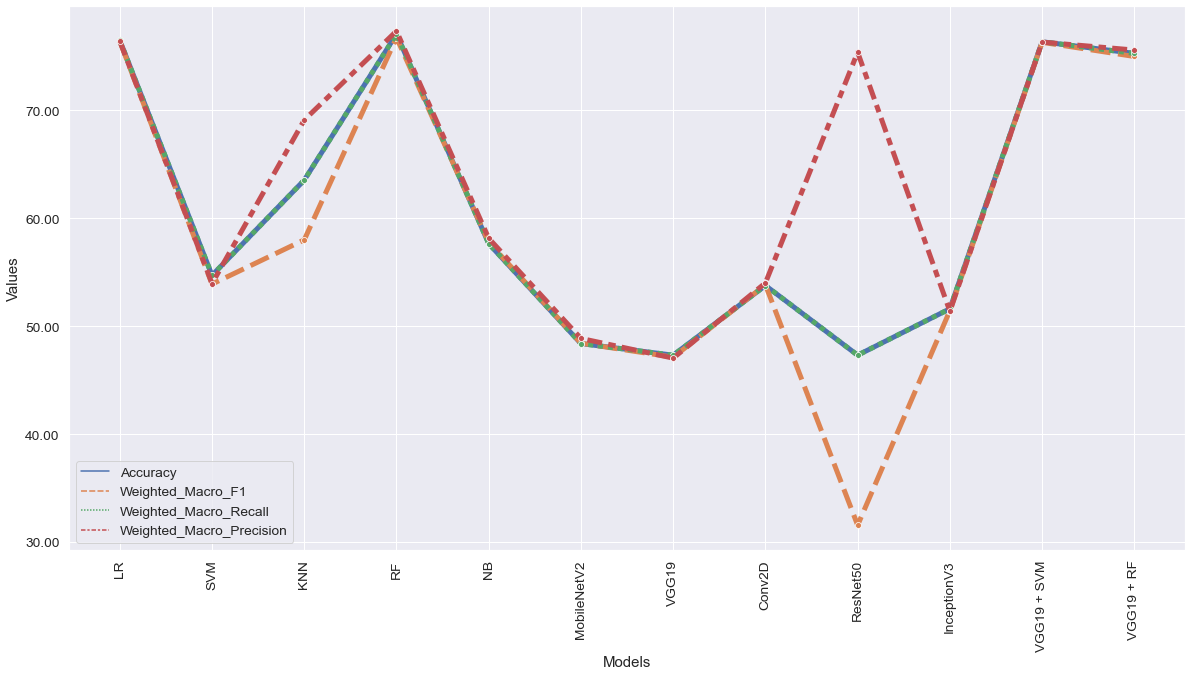

In [53]:
import seaborn as sns
from matplotlib import style
from matplotlib.ticker import FormatStrFormatter

fig, ax = plt.subplots(figsize=(20, 10))

ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
style.use("ggplot")
# plt.figure(figsize=(20, 10))
sns.set(font_scale=1.25)
g = sns.lineplot(data=df_new, marker="o", estimator=None, linewidth=5)
g.set_xticks(range(len(names)), rotatation=90)
g.set_xticklabels(names, rotation=90)
g.set(xlabel="Models", ylabel="Values")

In [1]:
import pickle
obj = pickle.load(open("crs_ann", "rb"))

In [3]:
print(obj)

{'name': ['LR', 'SVM', 'KNN', 'RF', 'NB'], 'cr': [{'accuracy': 0.7647058823529411, 'macro avg': {'precision': 0.7627551020408163, 'recall': 0.7595184770436729, 'f1-score': 0.7606981981981982, 'support': 170}, 'weighted avg': {'precision': 0.7641056422569027, 'recall': 0.7647058823529411, 'f1-score': 0.7639772125066242, 'support': 170}, 'Positive': {'precision': 0.75, 'recall': 0.7105263157894737, 'f1-score': 0.7297297297297298, 'support': 76}, 'Negative': {'precision': 0.7755102040816326, 'recall': 0.8085106382978723, 'f1-score': 0.7916666666666665, 'support': 94}}, {'accuracy': 0.5470588235294118, 'macro avg': {'precision': 0.5348924650323357, 'recall': 0.5324748040313549, 'f1-score': 0.5293229297759878, 'support': 170}, 'weighted avg': {'precision': 0.5394548494687392, 'recall': 0.5470588235294118, 'f1-score': 0.5389970536414918, 'support': 170}, 'Positive': {'precision': 0.4918032786885246, 'recall': 0.39473684210526316, 'f1-score': 0.43795620437956206, 'support': 76}, 'Negative': {